# Regularización

Experimentos de control de capacidad.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy             as np
import numpy             as np
import numpy.linalg      as la

Usaremos MNIST, seleccionando dos categorías

In [2]:
# wget http://robot.inf.um.es/material/mnist.npz
mnist = np.load("../data/mnist.npz")

print(mnist.keys())

xl,yl,xt,yt = [mnist[d] for d in ['xl', 'yl', 'xt', 'yt']]

cl = np.argmax(yl,axis=1)
ct = np.argmax(yt,axis=1)

print(xl.shape, yl.shape, cl.shape)
print(xt.shape, yt.shape, ct.shape)

['yl', 'yt', 'xl', 'xt']
(60000, 784) (60000, 10) (60000,)
(10000, 784) (10000, 10) (10000,)


Seleccionamos dos clases y ponemos la salidad deseada de la máquina a valores +1 y -1

In [8]:
n = 100
ca = 4
cb = 9

# seleccionamos las posiciones de las clases que nos interesan
sel_l = (cl == ca) | (cl==cb)
sel_t = (ct == ca) | (ct==cb)

# extraemos esas posiciones
# x e y seleccionadas para aprendizaje
# usaré solo los n primeros para aprender
xsl = xl[sel_l][:n]
ysl = cl[sel_l].astype(int)[:n]

# y ponemos correctamente los valores deseados, positivo o negativo
ysl[ysl==ca] =  1
ysl[ysl==cb] = -1

# y lo mismo para el x e y seleccionadas para test (evaluación independiente)
xst = xt[sel_t]
yst = ct[sel_t].astype(int)

yst[yst==ca] =  1
yst[yst==cb] = -1

In [9]:
np.sum(sel_l)

11791

In [10]:
def shdig(v):
    x = np.reshape(v,[28,28])
    plt.imshow(1-x, 'gray', vmin=0, vmax=1, interpolation="nearest");

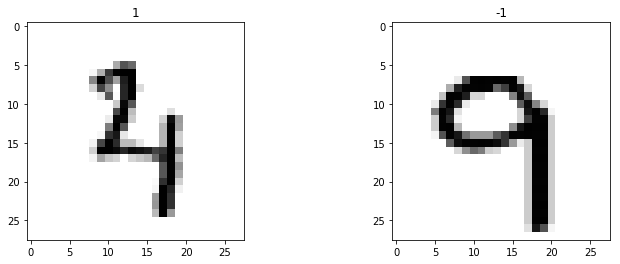

In [43]:
k1,k2 = 55, 56
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
shdig(xsl[k1])
plt.title(ysl[k1])
plt.subplot(1,2,2)
shdig(xsl[k2])
plt.title(ysl[k2]);

In [16]:
xsl.shape

(100, 784)

In [17]:
yst

array([ 1,  1, -1, ...,  1, -1,  1])

conveniente para añadir el término independiente (offset) a una máquina lineal

In [18]:
def homog(x):
    r,c = x.shape
    return np.hstack([x, np.ones([r,1])])

solución de mínimos cuadrados para un sistema lineal

Deseo encontrar $W$ tal que `xsl @ w = ysel`

O sea, resolver $X w= y$

Usarmos `lstsq` del módulo de álgebra lineal `numpy.linalg`, que obtiene la solución de mínimo error cuadrático de un sistema (ver el notebook de [sistemas de ecuaciones](sistecs.ipynb)).

`lstsq` no es lo ideal para mostrar este efecto en el caso no regularizado, porque para sistemas subdeterminados obtiene la solución de mínima norma, y por tanto, también regulariza.

In [23]:
W,_,_,_ = la.lstsq(homog(xsl),ysl)

/home/brutus/apps/miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  """Entry point for launching an IPython kernel.


In [24]:
#W

In [25]:
#homog(xsl) @ W

In [26]:
#np.sign(homog(xsl) @ W) == np.sign(ysl)

contamos los aciertos

In [27]:
np.sum(np.sign(homog(xsl) @ W) == np.sign(ysl)), len(ysl)

(100, 100)

Tiene buena pinta, acierta todos los ejemplos de entrenamiento.

In [34]:
np.sign(homog(xst) @ W) == np.sign(yst)

array([ True,  True,  True, ...,  True,  True,  True])

In [35]:
np.sum(np.sign(homog(xst) @ W) == np.sign(yst)), len(yst)

(1740, 1991)

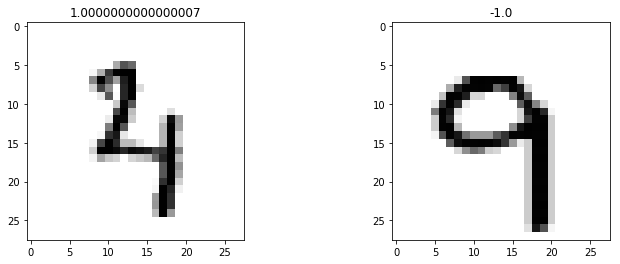

In [44]:
k1,k2 = 55, 56
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
shdig(xsl[k1])
plt.title((homog(xsl) @ W)[k1])
plt.subplot(1,2,2)
shdig(xsl[k2])
plt.title((homog(xsl) @ W)[k2]);

Obtiene exactamente los valores deseados $\pm 1$, ya que tiene más grados de libertad (coeficientes ajustables) que restricciones (ecuaciones, número de ejemplos de entrenamiento). Esto inspira poca confianza en el comportamiento con ejemplos desconocidos:

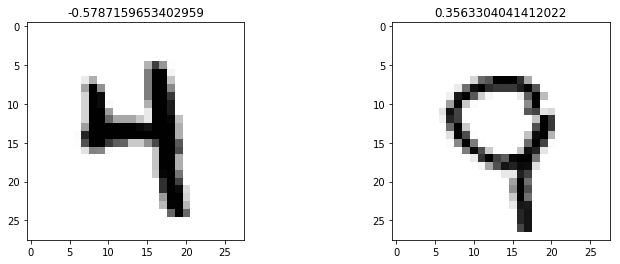

In [46]:
k1,k2 = 70, 55
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
shdig(xst[k1])
plt.title((homog(xst) @ W)[k1])
plt.subplot(1,2,2)
shdig(xst[k2])
plt.title((homog(xst) @ W)[k2]);

Vamos a construir una solución regularizada, que penaliza con un peso $\lambda$ el tamaño de los coeficientes, para que se reduzca la interpolación de detalles irrelevantes.

La solución regularizada es muy parecida a la de mínimos cuadrados, pero hay que "inflar" la covarianza $X^TX$ con $\lambda$. En lugar de 

$w = (X^T X) ^{-1} X^T y$

(esto es lo que hace internamente lstsq, es la "pseudoinversa" de X, por y)

hacemos

$w = (X^T X + \lambda I) ^{-1} X^T y$

In [47]:
lam = 2E2

D = np.diag(lam*np.ones([784+1]))
D[-1,-1] = 0
# el coeficiente  b no se regulariza,
# porque la posición del hiperplano puede ser cualquiera, no hay que 
# promover que se acerque al origen

In [281]:
#D

In [48]:
xh = homog(xsl)
Wr = la.solve(xh.T @ xh + D, xh.T @ ysl)

In [49]:
np.sum(np.sign(homog(xsl) @ Wr) == np.sign(ysl)), len(ysl)

(98, 100)

In [50]:
np.sum(np.sign(homog(xst) @ Wr) == np.sign(yst)), len(yst)

(1846, 1991)

**Ejercicio**: crea una curva comparando $E_L$ con $E_T$ para valores crecientes de $\lambda$.

In [77]:
Lam = [0.01, 0.1, 1, 5, 10, 50, 100, 200, 500, 1000, 2000, 3000, 5000]

def regu():
    xh = homog(xsl)
    L = []
    T = []
    for l in Lam:
        lam = 2E2
        D = np.diag(l*np.ones([784+1]))
        D[-1,-1] = 0
        Wr = la.solve(xh.T @ xh + D, xh.T @ ysl)
        EL = np.sum(np.sign(homog(xsl) @ Wr) == np.sign(ysl)), len(ysl)
        ET = np.sum(np.sign(homog(xst) @ Wr) == np.sign(yst)), len(yst)
        L.append(EL[0]/EL[1])
        T.append(ET[0]/ET[1])
    return 1-np.array(L), 1-np.array(T)

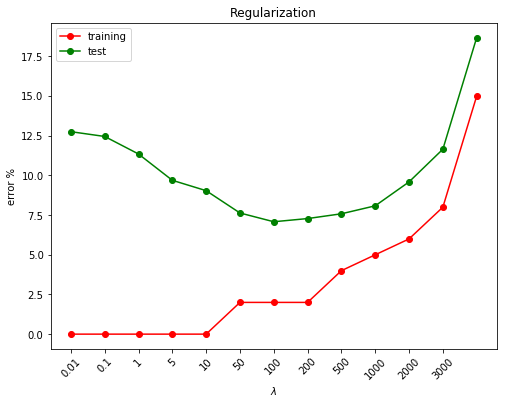

In [93]:
plt.figure(figsize=(8,6))
l,t = regu()
plt.plot(100*l,'o-',label='training',color='red')
plt.plot(100*t,'o-',label='test',color='green')
plt.xticks(np.arange(12), Lam, rotation=45)
plt.legend()
plt.xlabel('$\lambda$'); plt.ylabel('error %')
plt.title('Regularization');

Esta gráfica ilustra el principio teórico fundamental de *machine learning*: la **generalización** está relacionada con la **capacidad** de la máquina. 